# **Accelerated SGD**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [3]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

Continuing from the previous NB, we will push to improve the model's performance beyong 90%. 

## **Import Data and Setup**

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu)) # Using GeneralRelu from before
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## **Optimizers**

### **Custom SGD Class**

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params) # module.params returns a generator, so we'll use list()
        fc.store_attr()
        self.i = 0 # track batch numbers

    def step(self):
        with torch.no_grad():
            for p in self.params:
                # For each tensor of params do one step of the regularizer and one step for the optimizer.
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1 # track batches

    def opt_step(self, p): p -= p.grad * self.lr # From the parameter subtract the gradient from the learning rate 

    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_() # For each param zero the gradients

In [8]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.845,0.424,1,train
0.850,0.416,1,eval
0.865,0.373,2,train
0.845,0.414,2,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


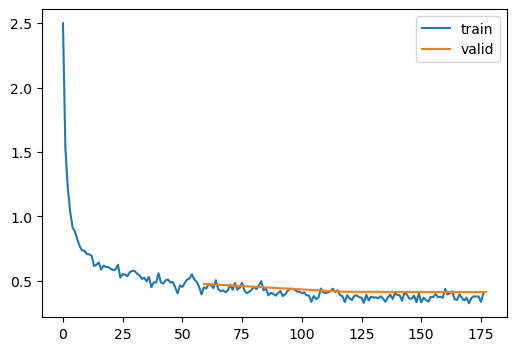

In [9]:
learn.fit(3)

### **A Note on Weight Decay**

Weight decay and L2 regularization are often used interchangeably. The difference is subtle but clear, as this [blog](https://benihime91.github.io/blog/machinelearning/deeplearning/python3.x/tensorflow2.x/2020/10/08/adamW.html) points out.

> The major difference between L2 regularization & weight decay is while the former modifies the gradients to add `lamdba * w` , weight decay does not modify the gradients but instead it subtracts `learning_rate * lamdba * w` from the weights in the update step.

When written in code, the difference becomes clearer still:

`L2 Regularization`
```
weight -= lr * wd * weight
```
`Weight Decay`
```
weight.grad += wd * weight
```


> ...weight decay and L2 regularization may seem the same and it is infact same for vanilla SGD , but as soon as we add momentum, or use a more sophisticated optimizer like Adam, L2 regularization and weight decay become different. 

## **Momentum Revisited**

We will now proceed to add Momentum to our optimizer. But first, let's create some data points and plot them with different momentum values to demonstrate how it works.

In [10]:
# Generating random data
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3)**2 + torch.randn(100) * 0.1

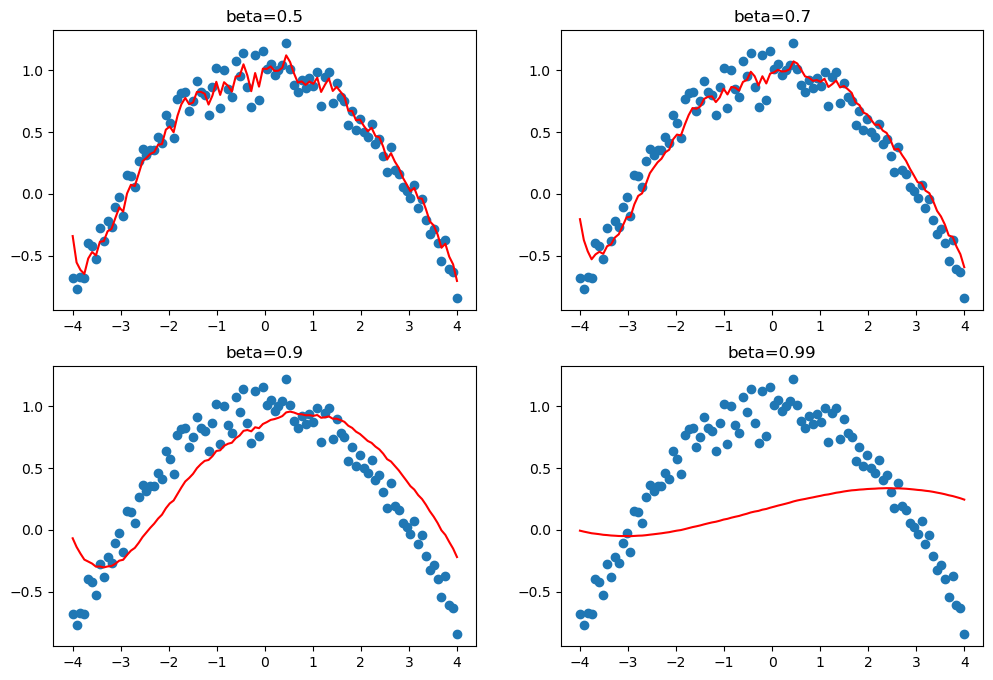

In [11]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
# Levels of momentum
betas = [0.5, 0.7, 0.9, 0.99]

for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        # This is effectively doing a LERP
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs, np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [12]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9): # As before, FastAI's momentum is the opposite of PyTorch's implementation
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom

    def opt_step(self, p):
        # Check for stored values of grad_avg, by creating a new attribute within the opt_step function
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom) # MomentumLearner didn't feature the lerp i.e. (1-self.mom)
        # Key difference with SGD.
        p -= self.lr * p.grad_avg        

In [13]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.786,0.596,0,train
0.846,0.416,0,eval
0.869,0.359,1,train
0.859,0.374,1,eval
0.886,0.312,2,train
0.867,0.368,2,eval


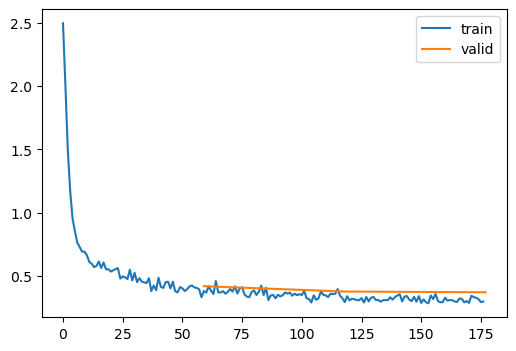

In [14]:
learn.fit(3)

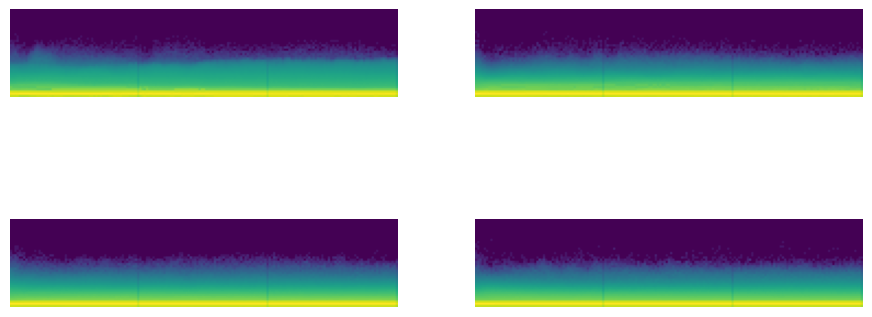

In [15]:
astats.color_dim()

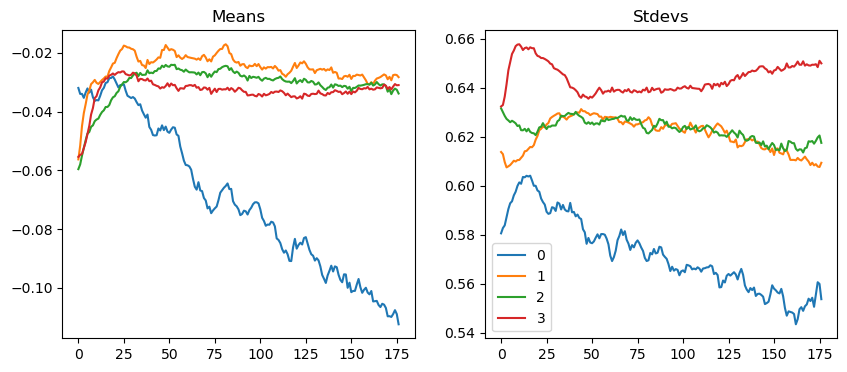

In [16]:
astats.plot_stats()

## **RMS Prop**

RMS Prop was introduced as part of a [Coursera course's lecture slides](http://www.cs.toronto.edu/~hinton/coursera/lecture6/lec6.pdf) by Geoffery Hinton.

A more detailed walkthrough can be found on [Machine Learning Mastery.](https://machinelearningmastery.com/gradient-descent-with-rmsprop-from-scratch/).

Effectively, we will be lerping on `p.grad**2` and will call the momentum multiplier `self.sqr_mom`. Here large `p.grad**2` values indicate a high degree of variance within the gradients. Thus the division will be taken with the square root of the `p.sqr_avg`.

In [17]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.765,0.665,0,train
0.822,0.483,0,eval
0.849,0.415,1,train
0.845,0.425,1,eval
0.866,0.367,2,train
0.852,0.401,2,eval


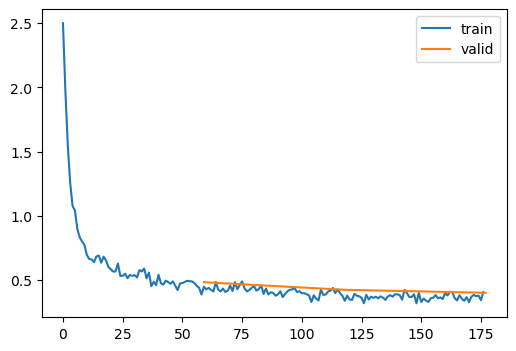

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

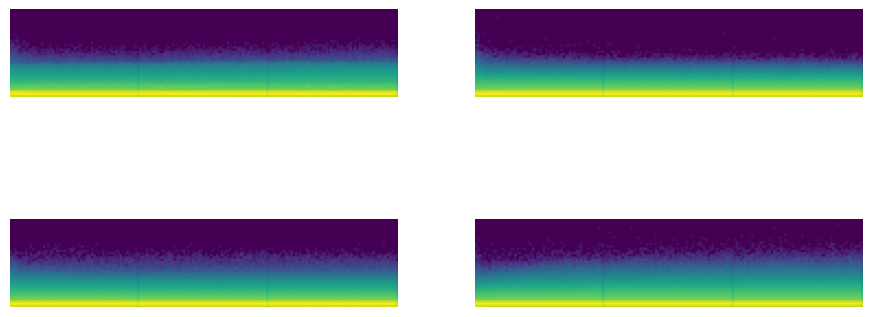

In [19]:
astats.color_dim()

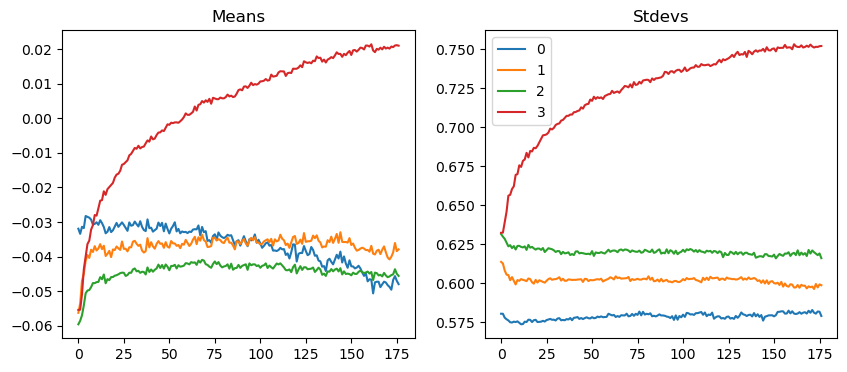

In [20]:
astats.plot_stats()

RMS Prop can be quite handy when use with more complex architectures like EfficientNet, whereas Momentum can be quite aggressive.

## **Adam**

By combining RMSProp and Momentum, we get the popular optimizer `Adam`. The details can be found in the paper ["Adam: A Method for Stochastic Optimization"](https://arxiv.org/abs/1412.6980).

In [21]:
class Adam(SGD):
    # beta1 & beta2 can be called momentum and square momentum
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        # if p doesn't already have these attribs they are initialized to tensors of 0
        # with the same shape as the gradient `p.grad`
        if not hasattr(p, 'avg'):     p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        # Update exponential moving average of the gradient
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        # Correct the bias introduced by initializing `p.avg` to zero
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        # Update exponential moving average of the squared gradient
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        # Correct the bias of the above
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.583,0,train
0.840,0.428,0,eval
0.870,0.359,1,train
0.858,0.380,1,eval
0.886,0.311,2,train
0.874,0.344,2,eval


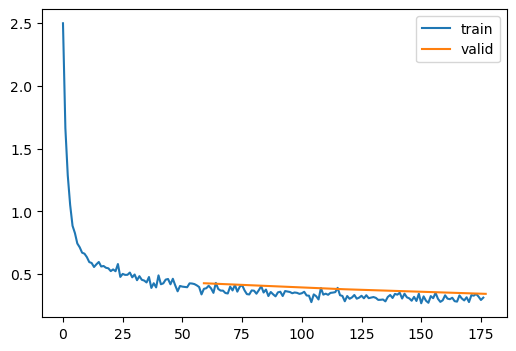

In [22]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

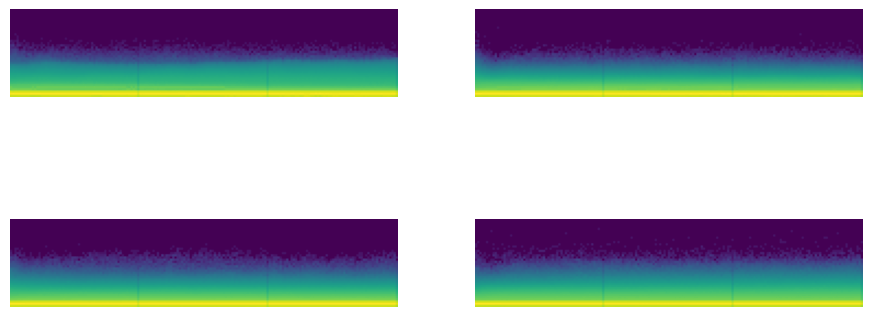

In [23]:
astats.color_dim()

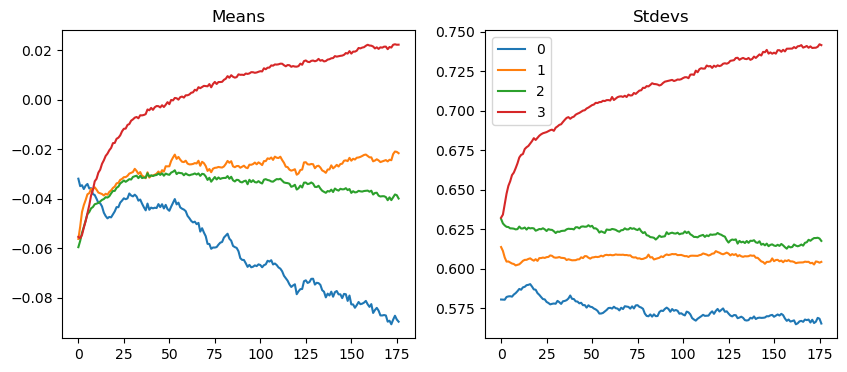

In [24]:
astats.plot_stats()

## **Schedulers**

Fine-tuning and adapting the learning rate (LR) for SGD optimizers can help increase performance while reducing training time. This usually takes the form of small reductions in the learning rate and is commonly referred to as _annealing_.

Recall that we have already implemented a LR adjustment callback in the form of `LRFinderCB()`, and our `Learner` also shares the same functionality, although to a lesser degree. Also, the option to use predefined PyTorch schedulers is ever present.

PyTorch already has a really well rounded scheduler in the form of `torch.optim.lr_scheduler()`.

In [25]:
?lr_scheduler

Type:        module
String form: <module 'torch.optim.lr_scheduler' from '/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/optim/lr_scheduler.py'>
File:        ~/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/optim/lr_scheduler.py
Docstring:   <no docstring>

In [26]:
# Using dir() to show all modules in the object
# this also shows hidden dunder modules 
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_enable_get_lr_call',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [27]:
# filtering down to the modules of interest i.e. those starting with capitals
# followed by lowercase letters.
' -- '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler -- ConstantLR -- CosineAnnealingLR -- CosineAnnealingWarmRestarts -- Counter -- CyclicLR -- ExponentialLR -- LambdaLR -- LinearLR -- MultiStepLR -- MultiplicativeLR -- OneCycleLR -- Optimizer -- PolynomialLR -- ReduceLROnPlateau -- SequentialLR -- StepLR'

In [28]:
# The same display can be recreated using
' -- '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler -- ConstantLR -- CosineAnnealingLR -- CosineAnnealingWarmRestarts -- Counter -- CyclicLR -- ExponentialLR -- LambdaLR -- LinearLR -- MultiStepLR -- MultiplicativeLR -- OneCycleLR -- Optimizer -- PolynomialLR -- ReduceLROnPlateau -- SequentialLR -- StepLR'

Before we proceed, it is important to note that PyTorch schedulers won't work with our custom optimizer class. So we will be working with the PyTorch API for this purpose.

The simplest way to access the optimizer is to initialize a learner and accedd the optimizer after calling `fit()`, and we can use the `SingleBatchCB()` callback to run only one epoch in this instance.

In [29]:
# Create a basic learner and call SingleBatchCB()
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [30]:
opt = learn.opt

In [31]:
# Here we can list the parameter groups for optim.sgd.SGD since that was the default optimizer in the TrainLearner() class.
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [32]:
' -- '.join(o for o in dir(opt) if o[0] != '_')

'add_param_group -- defaults -- load_state_dict -- param_groups -- profile_hook_step -- register_step_post_hook -- register_step_pre_hook -- state -- state_dict -- step -- zero_grad'

Let's take a closer look at the optimizer's `parameter groups`. 

In [33]:
# Parameter groups are in a generator 
param = next(iter(learn.model.parameters()))
state = opt.state[param]

In [34]:
# Uncomment to view the state dictionary
# opt.state

In [35]:
# The state is a dictionary, with keys being the parameter tensors.
state

{'momentum_buffer': None}

The key difference between FastAI's and PyTorch's approach to optimizers is that FastAI stores optimizer states **directly as attributes**, as we have done in previous sections in this notebook. PyTorch, on the other hand stores the parameter state **in a dictionary**.

Moving to parameters, FastAI stores these as lists after passing them through a generator:

```
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0 
```

While PyTorch stores these as parameter groups.

In [36]:
# Length of the group
len(opt.param_groups)

1

In [37]:
# Elements of the group
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

Let's now create a `CosineAnnealingSchedulerLR()` scheduler, and we can pass it the optimizer. Doing so will allow us implement variable learning rate methodologies for the start (earlier layers) and end of the training process (later layers).

In [38]:
# Passing our optimizer to scheduler
sched = lr_scheduler.CosineAnnealingLR(opt, T_max=100)

In [39]:
# The base learning rate was acquired from the optimizer
sched.base_lrs

[0.006]

In [40]:
# This shows the  most recent learning rate.
sched.get_last_lr()

[0.006]

In [41]:
# Creating a function to plot the scheduler's learning rates
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step() # Scheduler adjusts the learning rate.
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

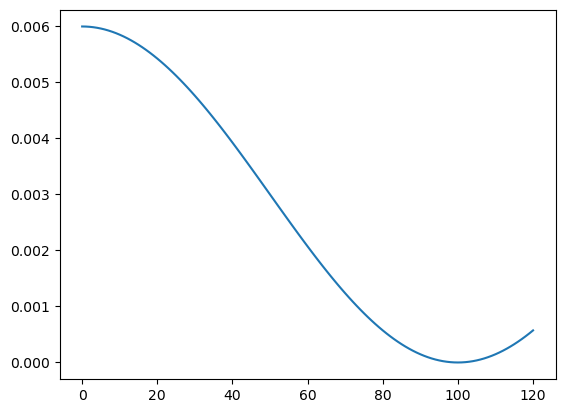

In [42]:
sched_lrs(sched, 120)

### **Scheduler Callbacks**

Having played around with the scheduler, let's create a callback class.

In [43]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    
    def before_fit(self, learn): 
        # Create scheduling object that takes the optimizer in the callable
        self.schedo = self.sched(learn.opt)

    def _step(self, learn):
        if learn.training: self.schedo.step()

In [44]:
# If we want the scheduler to run / update after every batch
# The scheduler can be run after epochs as well.
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [45]:
# This is a nicer way of handling learner
# Initially we were putting the object itself into self.learn in each callback
# that also included self.learn.model(), self.learn.opt() etc. so NOT optimal
# now run_cbs() passes learner as a parameter. So learn has to be passed as a parameter in
# all the callback methods.
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn
    def after_fit(self, learn) : self.learn = None

In [46]:
# We will need to store and recall the scheduler's operations, this callback serves that purpose.
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d

    def before_fit(self, learn):
        # Dictionary of recorded items
        self.recs = {k:[] for k in self.d}
        # Grab the first parameter group
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training: return
        # Cycle through the items of the dictionary
        for k, v in self.d.items():
            # Append the callable and pass the callback
            self.recs[k].append(v(self))

    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [47]:
# Function to assign parameter / hyperparameter to the callback
def _lr(cb): return cb.pg['lr']

In [48]:
len(dls.train)

59

In [49]:
# Create CosineAnnealingLR callable where tmax is 3 times the len of training mini batches in the dataloader
# fyi, we're using 3 here since we will be running 3 epochs.
tmax = 3 * len(dls.train)
# Using partial to set T_max for the callable.
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.807,0.524,0,train
0.852,0.405,0,eval
0.879,0.330,1,train
0.879,0.329,1,eval
0.897,0.282,2,train
0.880,0.317,2,eval


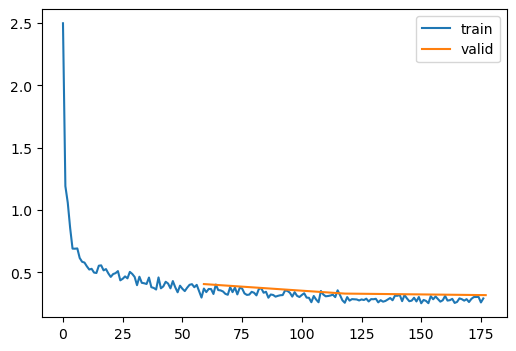

In [50]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr) # Passing the _lr function to check the learning rate
xtra = [BatchSchedCB(sched), rec] # Passing the BatchSchedCB with the sched callable, and recorder with _lr
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(3)

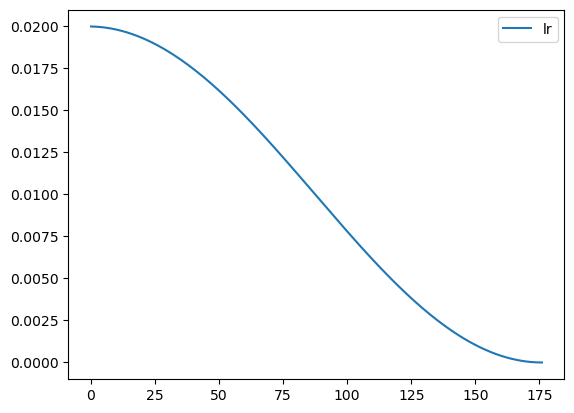

In [51]:
rec.plot()

In [52]:
# We can use the scheduler after each epoch as well
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.807,0.523,0,train
0.858,0.377,0,eval
0.879,0.328,1,train
0.874,0.333,1,eval
0.899,0.275,2,train
0.884,0.308,2,eval


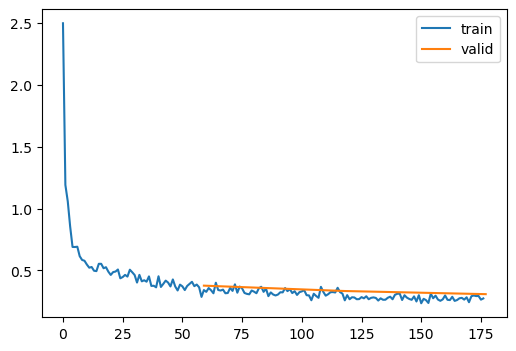

In [53]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3) # Stepping at the end of each epoch, not batch
set_seed(42)
xtra = [EpochSchedCB(sched), rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

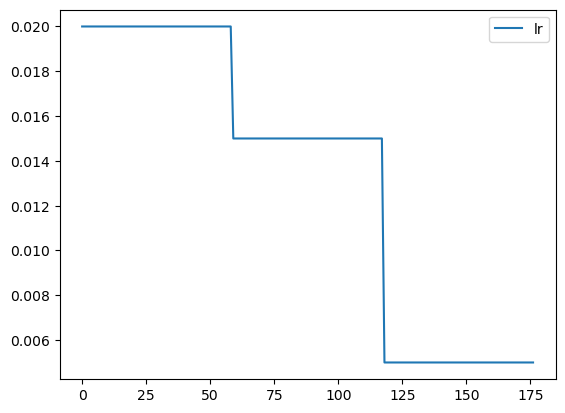

In [54]:
rec.plot()

### **1-Cycle Training Implementation**

[Leslie Smith's paper](https://arxiv.org/pdf/1803.09820) introduced the concept of 1-Cycle training, which basically states:

>  ...[It is a] modification of cyclical learning rate policy for super-convergence; always
use one cycle that is smaller than the total number of iterations/epochs and allow the learning rate to
decrease several orders of magnitude less than the initial learning rate for the remaining iterations.
We named this learning rate policy “1cycle” and in our experiments this policy allows the accuracy
to plateau before the training ends.

In [55]:
def _beta1(cb): return cb.pg['betas'][0]
# Passing lr and momentums to the recorder i.e. momentums of the gradients & gradients squared
rec = RecorderCB(lr=_lr, mom=_beta1) 

accuracy,loss,epoch,train
0.767,0.659,0,train
0.843,0.462,0,eval
0.858,0.388,1,train
0.859,0.406,1,eval
0.884,0.311,2,train
0.882,0.322,2,eval
0.908,0.250,3,train
0.896,0.282,3,eval
0.921,0.213,4,train
0.903,0.267,4,eval


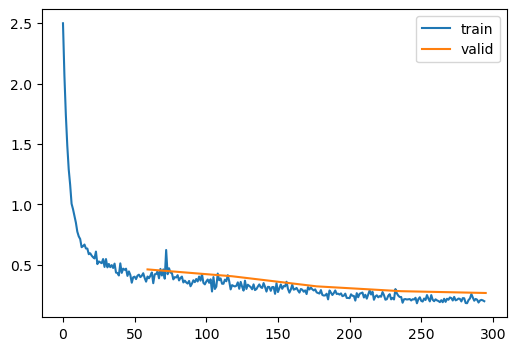

In [56]:
set_seed(42)

lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]

learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

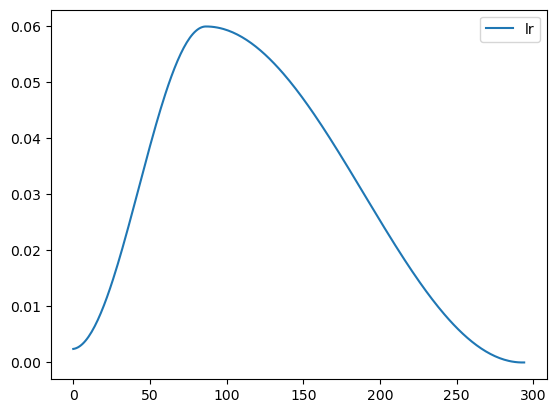

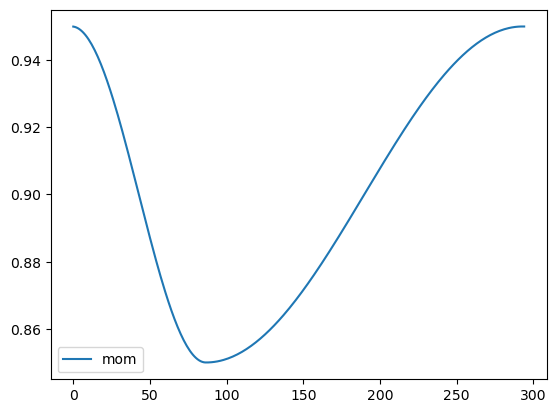

In [57]:
rec.plot()

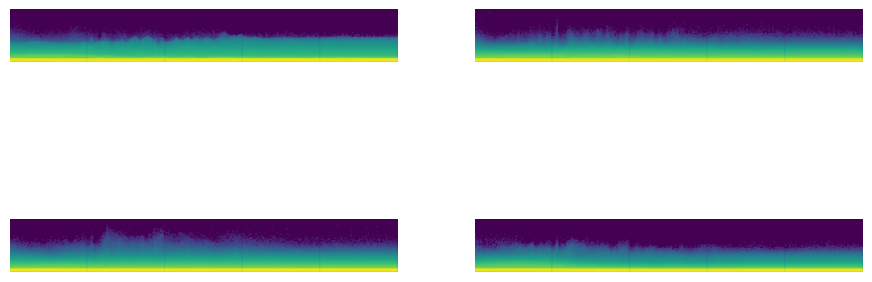

In [58]:
astats.color_dim()

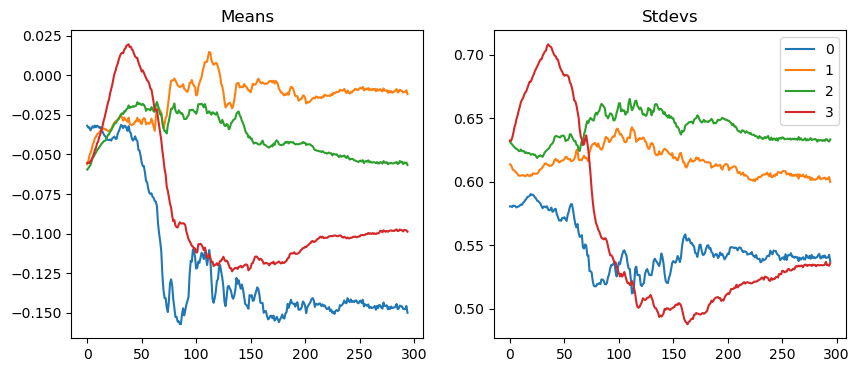

In [59]:
astats.plot_stats()

The amazing fact is that our "artisanal" neural network, with everything build out by hand, managed to hit **`90%`** accuracy!